# **<center> Modeling: Kaggle Competition </center>**
![Immune](https://i.imgur.com/0TSSaqL.png)  

In [24]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
import os
import pandas as pd
import json
import pickle
import optuna
import xgboost as xgb
from xgboost  import XGBRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from paths import RAW_DIR, PROCESSED_DIR, SUBMISSIONS_DIR, MODELS_DIR
from functions import compute_metrics, eval_best_model
from transformers import ExtractDataNeighborhood, FillNA, RemoveOutliersTransformer
import warnings
from datetime import datetime

warnings.filterwarnings('ignore')

RANDOM_STATE = 42

raw_train_df = pd.read_csv(os.path.join(RAW_DIR, 'train.csv'))
raw_predict_df = pd.read_csv(os.path.join(RAW_DIR, 'test.csv'))

In [26]:
raw_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17448 entries, 0 to 17447
Data columns (total 56 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            17448 non-null  int64  
 1   title                         17448 non-null  object 
 2   subtitle                      17448 non-null  object 
 3   sq_mt_built                   17348 non-null  float64
 4   sq_mt_useful                  6575 non-null   float64
 5   n_rooms                       17448 non-null  int64  
 6   n_bathrooms                   17434 non-null  float64
 7   n_floors                      1163 non-null   float64
 8   sq_mt_allotment               1146 non-null   float64
 9   latitude                      0 non-null      float64
 10  longitude                     0 non-null      float64
 11  raw_address                   13056 non-null  object 
 12  is_exact_address_hidden       17448 non-null  bool   
 13  s

In [27]:
# Split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(raw_train_df, raw_train_df['buy_price_by_area'], test_size=0.2, random_state=RANDOM_STATE, shuffle=True)

In [28]:
# Features for one-hot encoding
categorical_columns = ['floor', 'house_type_id', 'energy_certificate']

# Features for filling NA with False
fill_na_false_columns = [
    'has_lift', 
    'is_new_development', 
    'has_central_heating', 
    'has_ac', 
    'has_parking', 
    'is_exterior', 
    'has_garden', 
    'has_pool', 
    'has_terrace', 
    'has_balcony', 
    'has_storage_room', 
    'has_green_zones', 
    'has_fitted_wardrobes']

# Features for filling NA with True
fill_na_true_columns = [
    'is_parking_included_in_price',
    'is_renewal_needed'
]

# Numerical features
numerical_columns = ['sq_mt_built', 'n_rooms', 'n_bathrooms']

numeric_etl = ColumnTransformer(
    transformers=[
        ('remove_outliers', RemoveOutliersTransformer(['rent_price']), ['rent_price']),
        ('mean_price', ExtractDataNeighborhood(data='numerical'), ['neighborhood_id']),
        ('_', 'passthrough', numerical_columns),
    ],
    remainder='drop')


numeric_transformer = Pipeline(steps=[
    ('etl', numeric_etl),
    ('scaler', StandardScaler())  # Standardize numerical features
])

categorical_etl = ColumnTransformer(
    transformers=[
        ('loc_info', ExtractDataNeighborhood(data='categorical'), ['neighborhood_id']),
        ('cat_bool', FillNA(fill_na_false_columns, type_fill='False'), fill_na_false_columns),
        ('cat_bool_2', FillNA(fill_na_true_columns, type_fill='True'), fill_na_true_columns),
        ('_', 'passthrough', categorical_columns)
    ],
    remainder='drop')

categorical_transformer = Pipeline(steps=[
    ('etl', categorical_etl),
    ('onehot', OneHotEncoder(drop='if_binary', handle_unknown='ignore'))
])

etl_pipeline = FeatureUnion(
    transformer_list=[
        ('numeric', numeric_transformer),
        ('categorical', categorical_transformer)
    ])


In [29]:
etl_pipeline.fit(X_train, y_train)

# Transform the data
train_transformed = pd.DataFrame.sparse.from_spmatrix(etl_pipeline.transform(X_train), columns=etl_pipeline.get_feature_names_out())
train_transformed['buy_price_by_area'] = y_train.values
test_transformed = pd.DataFrame.sparse.from_spmatrix(etl_pipeline.transform(X_test), columns=etl_pipeline.get_feature_names_out())
test_transformed['buy_price_by_area'] = y_test.values

# Save in csv format
train_transformed.to_csv(os.path.join(PROCESSED_DIR, 'train.csv'), index=False)
test_transformed.to_csv(os.path.join(PROCESSED_DIR, 'test.csv'), index=False)


# # Object columns to categorical to avoid problems with xgboost
# object_cols = X_train_transformed.select_dtypes(include=['object']).columns
# X_train_transformed[object_cols] = X_train_transformed[object_cols].astype('category')
# X_test_transformed[object_cols] = X_test_transformed[object_cols].astype('category')

# X_train_transformed.info()

# # # Save in parquet format
# pd.DataFrame(X_train_transformed).to_parquet(os.path.join(PROCESSED_DIR, 'train.parquet'))
# pd.DataFrame(X_test_transformed).to_parquet(os.path.join(PROCESSED_DIR, 'test.parquet'))

In [30]:
# Import the data and create train and test sets
train_df = pd.read_csv(os.path.join(PROCESSED_DIR, 'train.csv'))
test_df = pd.read_csv(os.path.join(PROCESSED_DIR, 'test.csv'))

X_train = train_df.drop('buy_price_by_area', axis=1)
y_train = train_df['buy_price_by_area']

X_test = test_df.drop('buy_price_by_area', axis=1)
y_test = test_df['buy_price_by_area']

dtrain = xgb.DMatrix(X_train, label=y_train)

def objective(trial, dtrain):
    """Function to optimize the hyperparameters of the XGBoost model using Optuna"""
    
    # Define the hyperparameters to optimize
    optimize_params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.15, log=True),
        'max_depth': trial.suggest_int('max_depth', 4, 6),
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 1),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
    }

    fixed_params = {
        'booster': 'gbtree',
        'importance_type': 'gain',
        'n_jobs': -1,
        'objective': 'reg:squarederror',
        'nfolds': 5,
        'eval_metric': 'mape',
    }
   
    # xgbost cross validation
    results = xgb.cv({**optimize_params, **fixed_params}, 
                     dtrain,
                     seed=RANDOM_STATE)

    # Minimize the mape and the difference between train and test to avoid overfitting
    return results['test-mape-mean'].min() + abs(results['train-mape-mean'].min() - results['test-mape-mean'].min())

# Optimize the hyperparameters
study = optuna.create_study(direction='minimize', study_name='xgboost')

study.optimize(lambda trail: objective(trail, dtrain), n_trials=100, show_progress_bar=True)

# Get the best hyperparameters
best_params = study.best_params

# Create the XGBoost model with the best hyperparameters
model = XGBRegressor(**best_params)

# Fit the model
model.fit(X_train, y_train)

[I 2023-09-15 15:18:33,497] A new study created in memory with name: xgboost


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2023-09-15 15:18:33,708] Trial 0 finished with value: 0.3572779911899417 and parameters: {'learning_rate': 0.03440944469919862, 'max_depth': 6, 'n_estimators': 433, 'reg_alpha': 0.861480580294872, 'reg_lambda': 0.8464343640122108, 'subsample': 0.780284685608511, 'colsample_bytree': 0.7232432783522456, 'gamma': 0.7820056188701995, 'min_child_weight': 3}. Best is trial 0 with value: 0.3572779911899417.
[I 2023-09-15 15:18:33,884] Trial 1 finished with value: 0.2968716404414364 and parameters: {'learning_rate': 0.06357480911950616, 'max_depth': 5, 'n_estimators': 208, 'reg_alpha': 0.8088761528940739, 'reg_lambda': 0.4739212846874783, 'subsample': 0.9805927816599106, 'colsample_bytree': 0.5024553473237572, 'gamma': 0.2851120446633152, 'min_child_weight': 3}. Best is trial 1 with value: 0.2968716404414364.
[I 2023-09-15 15:18:34,055] Trial 2 finished with value: 0.4063894041900109 and parameters: {'learning_rate': 0.01846109671510063, 'max_depth': 4, 'n_estimators': 497, 'reg_alpha': 0.0

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.922365026542454, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0.11076744320759652,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.14928178658750288,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=213, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [31]:
# Save the model in pickle file
model_name = 'xgboost_model_' + datetime.now().strftime("%Y%m%d-%H%M%S") + '.pkl'
model_path = os.path.join(MODELS_DIR, model_name)

pickle.dump(model, open(model_path, 'wb'))

model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.922365026542454, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0.11076744320759652,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.14928178658750288,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=213, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [32]:
# show graphics of optuna optimization
optuna.visualization.plot_optimization_history(study)

In [33]:

optuna.visualization.plot_param_importances(study)

In [34]:
optuna.visualization.plot_slice(study)

In [35]:
optuna.visualization.plot_parallel_coordinate(study)

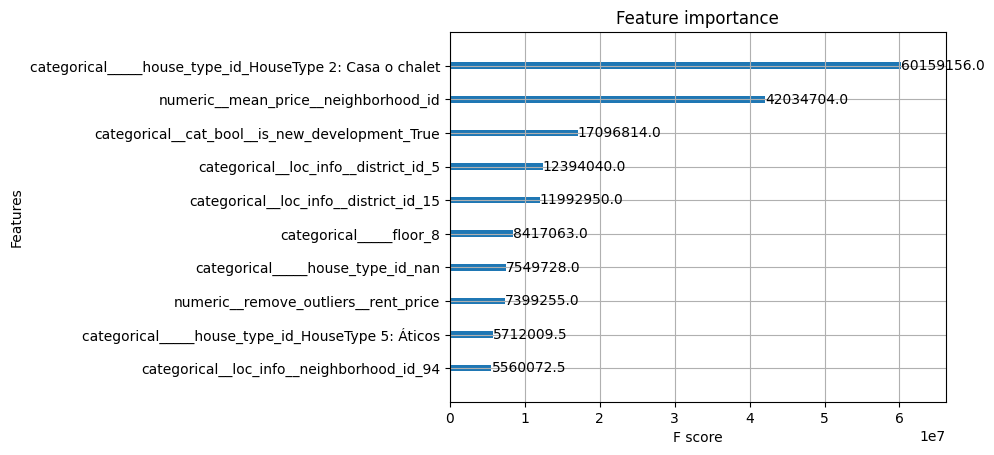

In [36]:
xgb.plot_importance(model, max_num_features=10, importance_type='gain');

In [37]:
# Make predictions on the test set
y_train_pred = model.predict(X_train)
y_pred = model.predict(X_test)

# Eval Model 
metrics = compute_metrics(model, y_test, y_pred, y_train, y_train_pred)


Train/Test split results:
XGBRegressor r2 is 0.897
XGBRegressor mean_squared_error is 374546.928
XGBRegressor mean_absolute_error is 276.189
XGBRegressor mape test is 0.061
XGBRegressor mape train is 0.030


In [38]:
# Save metrics and model parameters in json format
metrics_names = ('r2', 'mse', 'mae', 'mape_test', 'mape_train')

metrics_dict = {metric_name: metric_value for metric_name, metric_value in zip(metrics_names, metrics)}

to_save = {
    'model_fit_params': best_params,
    'model_params': model.get_params(),
    'metrics': metrics_dict
    }

with open(os.path.join(MODELS_DIR, f'metrics_{model.__class__.__name__}_{round(metrics_dict["mape_test"], 4)}_{datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}.json'), 'w') as f:
    json.dump(to_save, f)

## KAGGLE SUBMISSION

In [39]:
submission = eval_best_model(model, etl_pipeline, raw_predict_df)

submission.to_csv(os.path.join(SUBMISSIONS_DIR, f'submission_{model.__class__.__name__}_{round(metrics_dict["mape_test"], 4)}_{datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}.csv'), index=False)